<a href="https://colab.research.google.com/github/laysabelici/pyspark/blob/main/10_Preparando_dados_para_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#INSTALAR O SPARK NO COLAB
!pip install pyspark py4j

#IMPORTAR SPARK NO COLAB
from pyspark.sql import SparkSession

#CRIAR SESSÃO SPARK
spark = SparkSession.builder.appName("ExemploPySpark").getOrCreate()

#OBTER CONTEXTO SPARK PARA A SESSÃO
sc = spark.sparkContext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=ce11f282ab815c78d990bed53c2fdcfedc43efadd0f9ae15f610be900e1ba9a4
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [13]:
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [3]:
churn = spark.read.csv("/content/sample_data/Churn.csv",inferSchema=True, header=True, sep=";")
churn.show(3)

+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|        619|   France|Female| 42|     2|      0|            1|        1|             1|       10134888|     1|
|        608|    Spain|Female| 41|     1|8380786|            1|        0|             1|       11254258|     0|
|        502|   France|Female| 42|     8|1596608|            3|        1|             0|       11393157|     1|
+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
only showing top 3 rows



<ipython-input-14-851830e232e1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacao = churn.toPandas().corr()


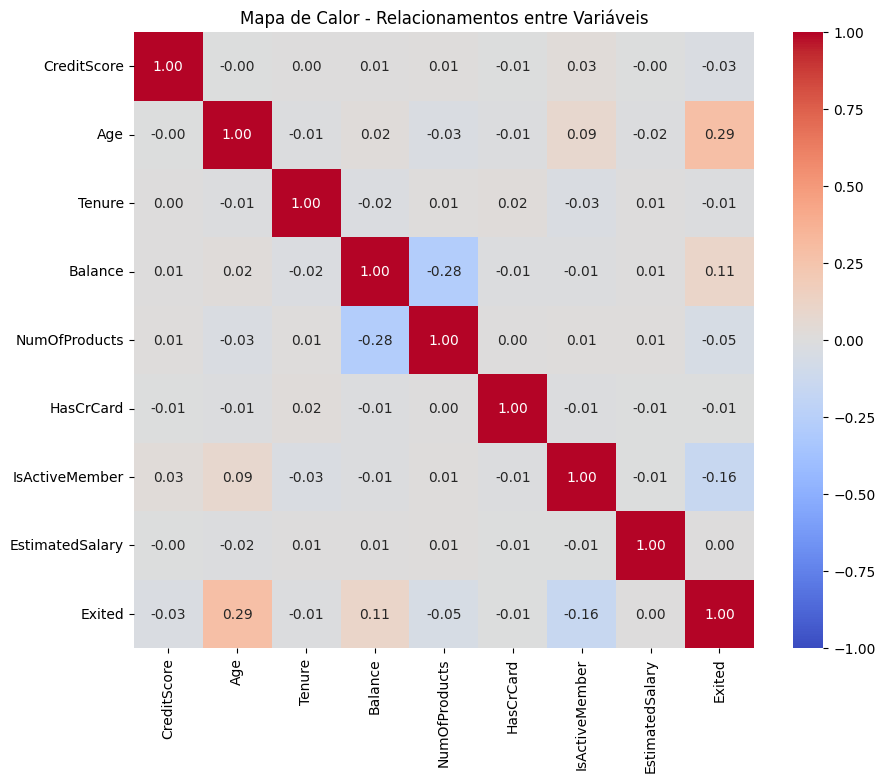

In [14]:
# Calcule a matriz de correlação
matriz_correlacao = churn.toPandas().corr()

# Configure o tamanho da figura
plt.figure(figsize=(10, 8))

# Crie o heatmap usando seaborn
sns.heatmap(matriz_correlacao, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)

# Adicione um título
plt.title('Mapa de Calor - Relacionamentos entre Variáveis')

# Exiba o heatmap
plt.show()

# Para criar uma fórmula que será usada em um pipeline de transformação. Vamos analisar cada parte da linha:

**RFormula:** É uma classe do Spark MLlib que é usada para definir fórmulas de modelagem linear em estilo R.

**formula="Exited ~ . "**: Define a fórmula de modelagem linear. Neste caso, a variável de resposta é "Exited", e o "~ ." indica que todas as outras variáveis no DataFrame devem ser usadas como preditores. Isso é semelhante à notação em R para especificar um modelo linear.

**featuresCol**="features": Define o nome da coluna onde as features (variáveis independentes) transformadas serão armazenadas.

**labelCol="label"**: Define o nome da coluna onde a variável de resposta (rótulo) será armazenada.

**handleInvalid="skip"**: Define como lidar com valores ausentes ou categorias não vistas durante o treinamento. Neste caso, "skip" significa que as linhas com valores ausentes ou categorias não vistas serão simplesmente ignoradas durante o treinamento.

In [4]:
#RFormula faz vários tipos de transformações
formula = RFormula(formula="Exited ~ . ",featuresCol="features", labelCol="label", handleInvalid="skip")

# Utilizando a fórmula criada anteriormente (utilizando RFormula) para transformar o DataFrame churn.

**formula.fit(churn)**: A função fit é usada para ajustar a fórmula aos dados. Neste caso, os dados são o DataFrame churn. Isso significa que a fórmula está sendo treinada com base nos dados fornecidos.

**.transform(churn)**: A função transform é usada para aplicar a fórmula treinada aos dados. Isso cria uma nova coluna chamada "features" (como definido anteriormente na fórmula) que contém as variáveis independentes transformadas.

.**select("features", "label")**: Por fim, a função select é usada para escolher as colunas "features" e "label" no DataFrame resultante. Essas são as colunas que serão utilizadas para treinar modelos de machine learning.

In [5]:
#aplicamos a formula e selecionamos apenas as colunas que interessam
churn_trans = formula.fit(churn).transform(churn).select("features","label")

In [6]:
#resultado
churn_trans.show(truncate=False)

+----------------------------------------------------------------+-----+
|features                                                        |label|
+----------------------------------------------------------------+-----+
|[619.0,1.0,0.0,0.0,42.0,2.0,0.0,1.0,1.0,1.0,1.0134888E7]        |1.0  |
|[608.0,0.0,0.0,0.0,41.0,1.0,8380786.0,1.0,0.0,1.0,1.1254258E7]  |0.0  |
|[502.0,1.0,0.0,0.0,42.0,8.0,1596608.0,3.0,1.0,0.0,1.1393157E7]  |1.0  |
|(11,[0,1,4,5,7,10],[699.0,1.0,39.0,1.0,2.0,9382663.0])          |0.0  |
|[850.0,0.0,0.0,0.0,43.0,2.0,1.2551082E7,1.0,1.0,1.0,790841.0]   |0.0  |
|[645.0,0.0,0.0,1.0,44.0,8.0,1.1375578E7,2.0,1.0,0.0,1.4975671E7]|1.0  |
|[822.0,1.0,0.0,1.0,50.0,7.0,0.0,2.0,1.0,1.0,100628.0]           |0.0  |
|[376.0,0.0,1.0,0.0,29.0,4.0,1.1504674E7,4.0,1.0,0.0,1.1934688E7]|1.0  |
|[501.0,1.0,0.0,1.0,44.0,4.0,1.4205107E7,2.0,0.0,1.0,749405.0]   |0.0  |
|[684.0,1.0,0.0,1.0,27.0,2.0,1.3460388E7,1.0,1.0,1.0,7172573.0]  |0.0  |
|[528.0,1.0,0.0,1.0,31.0,6.0,1.0201672E7,2.0,0.0,0.

# Dividimos o DataFrame churn_trans em dois conjuntos de dados: churnTreino e churnTeste, usando a função randomSplit. Vamos entender o que cada parte faz:

**churn_trans**: É o DataFrame que resultou da transformação utilizando a fórmula treinada.

**.randomSplit([0.7, 0.3])**: Esta função divide o DataFrame em dois conjuntos de dados aleatórios com base nas proporções fornecidas. Neste caso, 70% dos dados serão atribuídos ao conjunto de treinamento (churnTreino), e 30% dos dados serão atribuídos ao conjunto de teste (churnTeste).

Portanto, após a execução dessa linha de código, teremos dois DataFrames, churnTreino e churnTeste, que podem ser utilizados para treinar e avaliar modelos de machine learning.

O conjunto de treinamento geralmente é usado para treinar o modelo, enquanto o conjunto de teste é usado para avaliar o desempenho do modelo em dados não vistos. Essa prática é comum para evitar overfitting e avaliar a generalização do modelo.

In [7]:
churnTreino, churnTeste = churn_trans.randomSplit([0.7,0.3])

In [8]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
modelo = dt.fit(churnTreino)

In [9]:
previsao = modelo.transform(churnTeste)
previsao.show()

+--------------------+-----+--------------+--------------------+----------+
|            features|label| rawPrediction|         probability|prediction|
+--------------------+-----+--------------+--------------------+----------+
|(11,[0,1,3,4,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,3,4,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,4,5,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,4,5,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,4,5,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,4,5,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,4,5,7,10...|  1.0|  [86.0,314.0]|       [0.215,0.785]|       1.0|
|(11,[0,1,4,5,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,4,5,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,4,5,7,10...|  0.0|[4307.0,497.0]|[0.89654454621149...|       0.0|
|(11,[0,1,4,

# Estamos utilizando um BinaryClassificationEvaluator para avaliar o desempenho de um modelo de classificação binária. Vamos analisar o que cada parte faz:

**BinaryClassificationEvaluator**: É uma classe do Spark MLlib que é usada para avaliar modelos de classificação binária.

**rawPredictionCol="prediction"**: Especifica a coluna que contém as previsões cruas (antes da aplicação de qualquer limiar) do modelo. Geralmente, a coluna "prediction" contém essas previsões.

**labelCol="label"**: Especifica a coluna que contém os rótulos reais (verdadeiros) do conjunto de dados. Geralmente, a coluna "label" contém esses rótulos.

**metricName="areaUnderROC"**: Indica a métrica a ser usada para avaliação. Neste caso, está sendo utilizada a "Área sob a curva ROC" (Area Under the ROC Curve), comumente abreviada como "areaUnderROC".

**avaliar.evaluate(previsao)**: Esta linha avalia o modelo usando a métrica especificada. O DataFrame previsao deve conter as colunas "prediction" e "label".

**print(areaUnderROC)**: Imprime o resultado da avaliação, neste caso, a área sob a curva ROC.

Portanto, a linha de código completa está avaliando o modelo usando a métrica de área sob a curva ROC e imprimindo o resultado dessa avaliação. Isso fornece uma medida do desempenho do modelo na tarefa de classificação binária. Quanto maior a área sob a curva ROC, melhor é o desempenho do modelo.

In [10]:
#avaliar performance
#accuracy
avaliar = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label",metricName="areaUnderROC")
areaUnderROC = avaliar.evaluate(previsao)
print(areaUnderROC)

0.7215317974368887
